# X-Learner

* Meta-Learnerの手法の一つ
* 傾向スコアを使いT-Learnerの結果をさらに補正する手法

In [1]:
import random
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import scipy.stats
from scipy.special import expit
import pandas as pd

#LightGBMのインポート
import lightgbm as lgbm

## データの用意

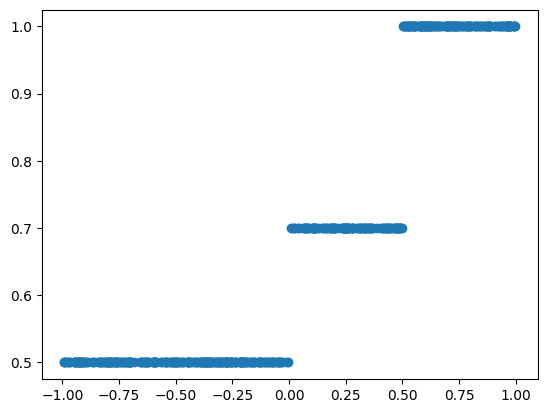

In [2]:
# データ数
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-5.0*x+5*e_z)
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 

# 介入効果を図で確認
plt.scatter(x, t, label="treatment-effect")

In [3]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   })

df.head()

,x,Z,t,Y
0,0.149289,0.0,0.7,2.008802
1,-0.601449,0.0,0.5,1.819586
2,0.349836,0.0,0.7,2.029080
3,-0.277833,1.0,0.5,2.440677
4,-0.738405,0.0,0.5,1.754613


## Z-Learner

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse'
}


categorical_features = []



# 介入を受けていない集団のモデル
df_0 = df[df.Z == 0.0]
x_train_0 = df_0[["x"]]
y_train_0 = df_0[["Y"]]

#LightGBM用の訓練データセットを作成
lgb_train_0 = lgbm.Dataset(x_train_0, y_train_0, categorical_feature=categorical_features, free_raw_data=False)


model_0 = lgbm.train(params = params,
                        train_set = lgb_train_0)




# 介入を受けた集団
df_1 = df[df.Z == 1.0]
x_train_1 = df_1[["x"]]
y_train_1 = df_1[["Y"]]
#LightGBM用の訓練データセットを作成
lgb_train_1 = lgbm.Dataset(x_train_1,y_train_1,categorical_feature=categorical_features,free_raw_data=False)

model_1 = lgbm.train(params = params,
                        train_set = lgb_train_1)

In [ ]:
tau_0 = model_1.predict(df_0[["x"]]) - df_0["Y"]
tau_1 = df_1["Y"] - model_0.predict(df_1[["x"]])


# ATTとATUを求めるモデルを作成します
x_train_2 = df_0[["x"]]
y_train_2 = tau_0
lgb_train_2 = lgbm.Dataset(x_train_2, y_train_2, categorical_feature=categorical_features, free_raw_data=False)


model_2 = lgbm.train(params = params,
                        train_set = lgb_train_2)



x_train_3 = df_1[["x"]]
y_train_3 = tau_1
lgb_train_3 = lgbm.Dataset(x_train_3,y_train_3,categorical_feature=categorical_features,free_raw_data=False)

model_3 = lgbm.train(params = params,
                        train_set = lgb_train_3)



## 傾向スコアを求める

In [29]:
# 説明変数
X = df[["x"]]
# 被説明変数（目的変数）
Z = df["Z"]

# 回帰の実施
lgb_train = lgbm.Dataset(X,Z,categorical_feature=categorical_features,free_raw_data=False)


params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': "binary",    # 分類を指定
          "metric":"binary_logloss"
}


model = lgbm.train(params = params,
                   train_set = lgb_train)

g_x_val_0 = model.predict(X)
g_x_val_1 = 1 - g_x_val_0

# それぞれのモデルで全データの効果を予測し、傾向スコアで調整
tau= g_x_val_1 * model_2.predict(df[["x"]]) + g_x_val_0 * model_3.predict(df[["x"]])

[LightGBM] [Info] Number of positive: 232, number of negative: 268
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.464000 -> initscore=-0.144250
[LightGBM] [Info] Start training from score -0.144250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


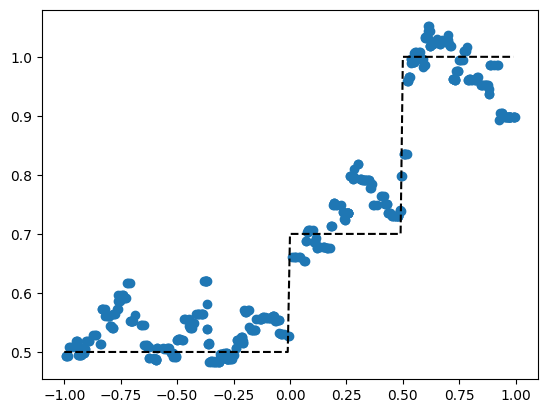

In [30]:
# 正解のグラフを作成
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0

# 推定された治療効果を各人ごとに求めます
plt.scatter(df[["x"]], tau, label="estimated_treatment-effect")

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')